In [6]:
import torch
from datasets.mnist import MNIST
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torchvision
import os

from nn.ae import AE
from train import train


device = torch.device('cpu')


In [4]:
train_dataset = MNIST(root='../../datasets', split='train', download=False, device=device)
val_dataset = MNIST(root='../../datasets', split='val', download=False, device=device)
test_dataset = MNIST(root='../../datasets', split='test', download=False, device=device)

In [3]:
experiment_name = 'test'
trial_name = 'trial'

model = AE(in_channels=1, z_dim=10).to(device)
optimiser = torch.optim.AdamW(model.parameters(), lr=1e-3)
num_epochs = 30
batch_size = 256
compute_dtype = torch.bfloat16

trial_log_dir = f'out/{experiment_name}/{trial_name}'
run_no = 0
while os.path.exists(trial_log_dir + f'/run_{run_no}'):
    run_no += 1
writer = SummaryWriter(trial_log_dir + f'/run_{run_no}')


train(model, train_dataset, val_dataset, optimiser, num_epochs=num_epochs, batch_size=batch_size, writer=writer, compute_dtype=compute_dtype)

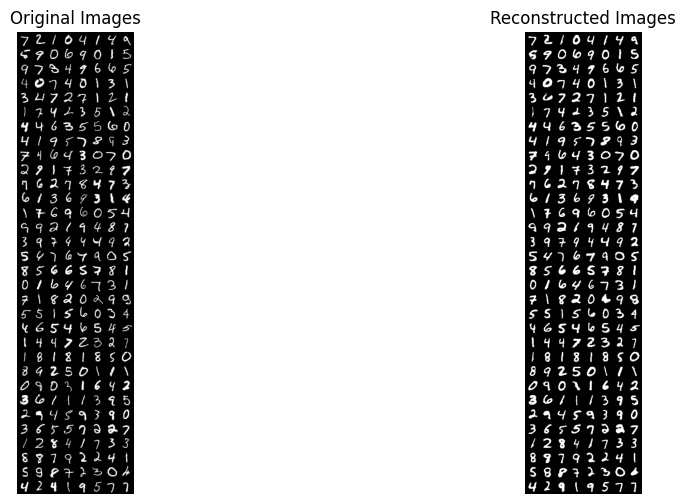

In [7]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

images, _= next(iter(test_loader))
x_hat = model.reconstruct(images)

import matplotlib.pyplot as plt

# Plot original images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(torchvision.utils.make_grid(images.cpu(), nrow=8, padding=2, normalize=True).permute(1, 2, 0))
axes[0].set_title('Original Images')
axes[0].axis('off')

# Plot reconstructed images
axes[1].imshow(torchvision.utils.make_grid(x_hat.cpu(), nrow=8, padding=2, normalize=True).permute(1, 2, 0))
axes[1].set_title('Reconstructed Images')
axes[1].axis('off')

plt.show()


